After reviewing the search parameters used until now, it turned out that the chimeric spectra search parameter was always turned on, thus resulting in spectra containing fragments of multiple peptides. As this project solely focusses on the effect of calibration, this parameter was turned off and the calibrations (LR and RF) were perfomred again on the PXD001468 and PXD032235 subset mzML files.

Initial Closed Search

- PXD001468 & PXD032235
- Human + contaminants FASTA
- Closed Search JSON

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

# Read and print shape of uncalibrated data (linear)
uncal_results = "results/sage/PXD001468_uncal.tsv"
df_uncal_results = pd.read_csv(uncal_results, sep='\t')
print("Lineair data uncalibrated:                    ", df_uncal_results.shape)

# Filtered uncalibrated data based on spectrum_q (linear)
df_uncal_results_q = df_uncal_results[df_uncal_results["spectrum_q"] < 0.01]
print("Lineair data uncalibrated q:                  ", df_uncal_results_q.shape)

uncal_results_nonlin = "results/sage/PXD032235_uncal.tsv"
df_uncal_results_nonlin = pd.read_csv(uncal_results_nonlin, sep='\t')
print("Non-linear data uncalibrated:                 ", df_uncal_results_nonlin.shape)

df_uncal_results_nonlin_q = df_uncal_results_nonlin[df_uncal_results_nonlin["spectrum_q"] < 0.01]
print("Non-linear data uncalibrated q:               ", df_uncal_results_nonlin_q.shape)

Lineair data uncalibrated:                     (38849, 36)
Lineair data uncalibrated q:                   (20126, 36)
Non-linear data uncalibrated:                  (59397, 36)
Non-linear data uncalibrated q:                (46414, 36)


Extract only scannr, peptide --> SE independent

In [3]:
df_uncal_results_q_copy = df_uncal_results_q.copy()
df_uncal_results_q = df_uncal_results_q[['scannr', 'peptide']]

df_uncal_results_nonlin_q_copy = df_uncal_results_nonlin_q.copy()
df_uncal_results_nonlin_q = df_uncal_results_nonlin_q[['scannr', 'peptide']]

In [4]:
# Read the corresponding mzML file
from pyteomics import mzml

uncal_mzML = "data/b1948_293T_proteinID_12B_QE3_122212.mzML"
uncal_spectra_list = []

# Open the mzML file for reading
with mzml.read(uncal_mzML) as reader:
    # Iterate over each spectrum in the mzML file
    for spectrum in reader:
        # Append the spectrum to the list
        uncal_spectra_list.append(spectrum)

# Print the number of spectra read
print("Number of spectra read:", len(uncal_spectra_list))

uncal_mzML_nonlin = "data/20210120_HM_HEK_IAA_300minGr_R1.mzML"
uncal_spectra_list_nonlin = []

# Open the mzML file for reading
with mzml.read(uncal_mzML_nonlin) as reader:
    # Iterate over each spectrum in the mzML file
    for spectrum in reader:
        # Append the spectrum to the list
        uncal_spectra_list_nonlin.append(spectrum)
        
# Print the number of spectra read
print("Number of spectra read:", len(uncal_spectra_list_nonlin))

Number of spectra read: 77338
Number of spectra read: 89175


In [5]:
from pyteomics import mass

modification_dict = {
    '[+15.9949]': 'ox',
    '[+57.0214]': 'cm'
}
print(modification_dict)

db = mass.Unimod()
aa_comp = dict(mass.std_aa_comp)
aa_comp['ox'] = db.by_title('Oxidation')['composition']
aa_comp['cm'] = db.by_title('Carbamidomethyl')['composition']
print(aa_comp)

{'[+15.9949]': 'ox', '[+57.0214]': 'cm'}
{'A': Composition({'H': 5, 'C': 3, 'O': 1, 'N': 1}), 'C': Composition({'H': 5, 'C': 3, 'S': 1, 'O': 1, 'N': 1}), 'D': Composition({'H': 5, 'C': 4, 'O': 3, 'N': 1}), 'E': Composition({'H': 7, 'C': 5, 'O': 3, 'N': 1}), 'F': Composition({'H': 9, 'C': 9, 'O': 1, 'N': 1}), 'G': Composition({'H': 3, 'C': 2, 'O': 1, 'N': 1}), 'H': Composition({'H': 7, 'C': 6, 'N': 3, 'O': 1}), 'I': Composition({'H': 11, 'C': 6, 'O': 1, 'N': 1}), 'J': Composition({'H': 11, 'C': 6, 'O': 1, 'N': 1}), 'K': Composition({'H': 12, 'C': 6, 'N': 2, 'O': 1}), 'L': Composition({'H': 11, 'C': 6, 'O': 1, 'N': 1}), 'M': Composition({'H': 9, 'C': 5, 'S': 1, 'O': 1, 'N': 1}), 'N': Composition({'H': 6, 'C': 4, 'O': 2, 'N': 2}), 'P': Composition({'H': 7, 'C': 5, 'O': 1, 'N': 1}), 'Q': Composition({'H': 8, 'C': 5, 'O': 2, 'N': 2}), 'R': Composition({'H': 12, 'C': 6, 'N': 4, 'O': 1}), 'S': Composition({'H': 5, 'C': 3, 'O': 2, 'N': 1}), 'T': Composition({'H': 7, 'C': 4, 'O': 2, 'N': 1}), '

In [6]:
def extract_features_uncal(row):
    scannr_value = int(row['scannr'].split("scan=")[-1])
    index_in_mzml = scannr_value - 1
    spectrum = uncal_spectra_list[index_in_mzml] 
    
    charge = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state']
    sequence = row['peptide']

    #Get expMZ
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
        and spectrum['precursorList']['precursor'] \
        and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
        and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:

        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz_str = selected_ion.get('selected ion m/z')
            if selected_ion_mz_str is not None:
                # Extract the numerical value from the string representation
                selected_ion_mz = float(selected_ion_mz_str)
                expMZ = float(selected_ion_mz)
                
                #return calcMZ, selected_ion_mz

    #get calcMZ
    for key, value in modification_dict.items():
        sequence = sequence.replace(key, value)
    seq = sequence
    if seq[-2:] == 'cm' or seq[-2:] == 'ox':
        if seq[-2:] == 'cm':
            extra_mass = mass.calculate_mass(aa_comp['cm'])
            seq = seq[:-2]
        elif seq[-2:] == 'ox':
            extra_mass = mass.calculate_mass(aa_comp['ox'])
            seq = seq[:-2]
    else:
        extra_mass = 0
    calmass = mass.calculate_mass(seq, aa_comp=aa_comp) + extra_mass
    if charge == 0 or charge is None:
        calcMZ = float(calmass)
        #return calcMZ
    else:
        calcMZ = float((calmass / charge) + 1.0072764667700085)
        #return calcMZ
        
    #Calculate deltaMZ
    deltaMZ = float(expMZ - calcMZ)
    # return expMZ, calcMZ, deltaMZ

    #get RT
    RT = float(spectrum['scanList']['scan'][0]['scan start time'])
    
    #get TIC
    TIC = float(spectrum['total ion current'])
        
    #get IT
    IT = float(spectrum['scanList']['scan'][0]['ion injection time'])
    
    return expMZ, calcMZ, deltaMZ, RT, TIC, IT




def extract_features_uncal_nonlin(row):
    scannr_value = int(row['scannr'].split("scan=")[-1])
    index_in_mzml = scannr_value - 1
    spectrum = uncal_spectra_list_nonlin[index_in_mzml] 
    
    charge = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['charge state']
    sequence = row['peptide']

    #Get expMZ
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
        and spectrum['precursorList']['precursor'] \
        and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
        and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:

        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz_str = selected_ion.get('selected ion m/z')
            if selected_ion_mz_str is not None:
                # Extract the numerical value from the string representation
                selected_ion_mz = float(selected_ion_mz_str)
                expMZ = float(selected_ion_mz)
                
                #return calcMZ, selected_ion_mz

    #get calcMZ
    for key, value in modification_dict.items():
        sequence = sequence.replace(key, value)
    seq = sequence
    if seq[-2:] == 'cm' or seq[-2:] == 'ox':
        if seq[-2:] == 'cm':
            extra_mass = mass.calculate_mass(aa_comp['cm'])
            seq = seq[:-2]
        elif seq[-2:] == 'ox':
            extra_mass = mass.calculate_mass(aa_comp['ox'])
            seq = seq[:-2]
    else:
        extra_mass = 0
    calmass = mass.calculate_mass(seq, aa_comp=aa_comp) + extra_mass
    if charge == 0 or charge is None:
        calcMZ = float(calmass)
        #return calcMZ
    else:
        calcMZ = float((calmass / charge) + 1.0072764667700085)
        #return calcMZ
       
    #Calculate deltaMZ
    deltaMZ = float(expMZ - calcMZ)
    # return expMZ, calcMZ, deltaMZ

    #get RT
    RT = float(spectrum['scanList']['scan'][0]['scan start time'])
    
    #get TIC
    TIC = float(spectrum['total ion current'])
        
    #get IT
    IT = float(spectrum['scanList']['scan'][0]['ion injection time'])
    
    return expMZ, calcMZ, deltaMZ, RT, TIC, IT

In [7]:
df_uncal_results_q_copy[['expMZ', 'calcMZ', 'deltaMZ', 'RT', 'TIC', 'IT']] = df_uncal_results_q_copy.apply(extract_features_uncal, axis=1, result_type='expand')
df_uncal_features = df_uncal_results_q_copy[['expMZ', 'RT', 'TIC', 'IT', 'deltaMZ']]

df_uncal_results_nonlin_q_copy[['expMZ', 'calcMZ', 'deltaMZ', 'RT', 'TIC', 'IT']] = df_uncal_results_nonlin_q_copy.apply(extract_features_uncal_nonlin, axis=1, result_type='expand')
df_uncal_features_nonlin = df_uncal_results_nonlin_q_copy[['expMZ', 'RT', 'TIC', 'IT', 'deltaMZ']]

Linear Regression (LR) Calibration

PXD001468

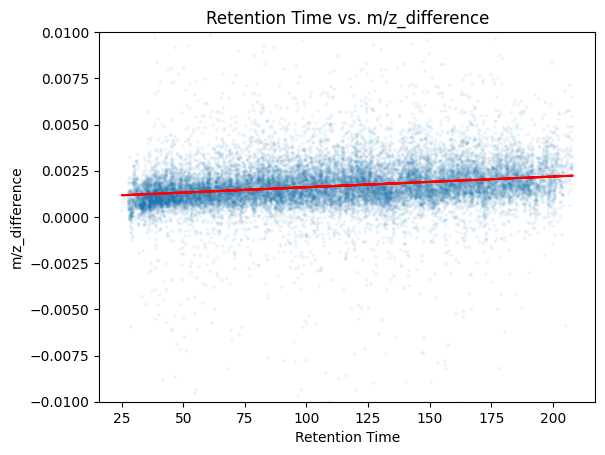

Slope: 5.780332870457856e-06
Intercept: 0.0010288450267847689


In [8]:
#Compute LR and get slope & intercept

import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_uncal_features['RT'], df_uncal_features['deltaMZ'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_uncal_features['RT']
y = df_uncal_features['deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

In [9]:
# substract LR 'predicted' deltaMZ from deltaMZ to compute LR adjusted deltaMZ
df_LR_results = df_uncal_features.copy()
df_LR_results['LR adj deltaMZ'] = df_LR_results['deltaMZ'] - (df_LR_results['RT'] * slope + intercept)
df_LR_results.head(5)

,expMZ,RT,TIC,IT,deltaMZ,LR adj deltaMZ
0,732.375183,63.545262,6076878.5,60.0,0.001966,0.000569
1,1068.018300,148.783380,13360974.0,60.0,0.003680,0.001791
2,847.855225,34.836664,2601142.0,60.0,0.001539,0.000308
3,889.445923,145.660350,4418031.5,60.0,0.001578,-0.000293
4,783.403198,187.849390,7656454.0,60.0,0.001643,-0.000471


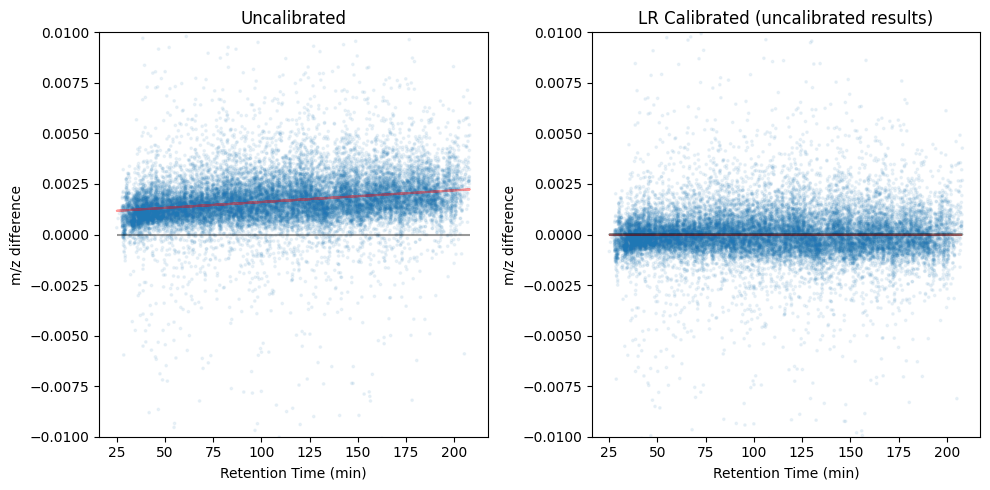

In [10]:
#Plot uncalibrated deltaMZ over RT & LR calibrated deltaMZ over RT

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
axs[0].scatter(df_LR_results['RT'], df_LR_results['deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_LR_results['RT']
y = df_LR_results['deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
axs[0].plot(x, polynomial(x), color='red', alpha=0.4)

# Get the x-range of the data in the second subplot
x_range = df_LR_results['RT']

# Add horizontal line at y=0 with the same x-range as the data in the second subplot
axs[0].hlines(0, min(x_range), max(x_range), colors='black', alpha=0.4)

axs[0].set_ylim(-0.01, 0.01)
axs[0].set_xlabel('Retention Time (min)')
axs[0].set_ylabel('m/z difference')
axs[0].set_title('Uncalibrated')

# Second subplot
axs[1].scatter(df_LR_results['RT'], df_LR_results['LR adj deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_LR_results['RT']
y = df_LR_results['LR adj deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

axs[1].hlines(0, min(x_range), max(x_range), colors='red', alpha=0.4)

axs[1].plot(x, polynomial(x), color='black', alpha=0.4)
axs[1].set_ylim(-0.01, 0.01)
axs[1].set_xlabel('Retention Time (min)')
axs[1].set_ylabel('m/z difference')
axs[1].set_title('LR Calibrated (uncalibrated results)')

plt.tight_layout()
plt.show()

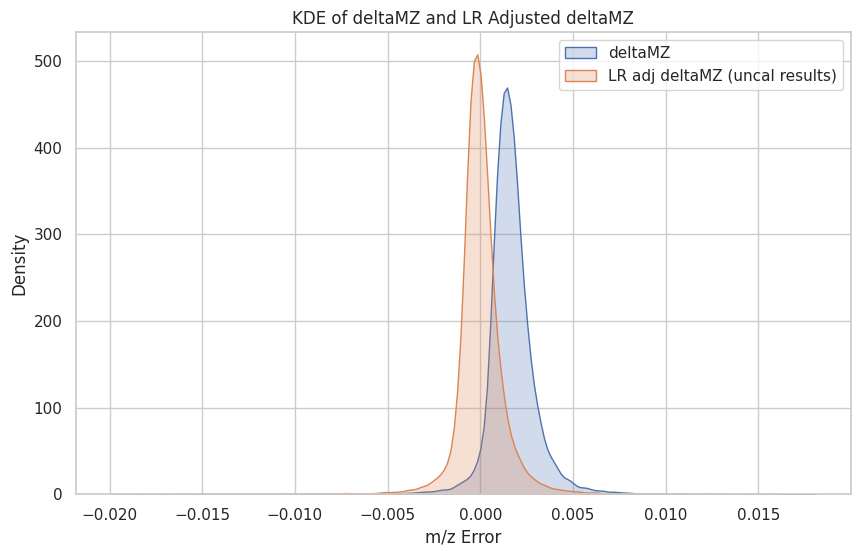

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot KDE for 'm/z error'
sns.kdeplot(df_LR_results['deltaMZ'], label='deltaMZ', fill=True)

# Plot KDE for 'RF predicted m/z error'
sns.kdeplot(df_LR_results['LR adj deltaMZ'], label='LR adj deltaMZ (uncal results)', fill=True)

# Set title and labels
plt.title('KDE of deltaMZ and LR Adjusted deltaMZ')
plt.xlabel('m/z Error')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

In [12]:
# Apply the LR model to ALL m/z values in the uncalibrated mzML file to adjust the expMZ values
from psims.transform.mzml import MzMLTransformer

def LRcal(spectrum):
    retention_time = spectrum['scanList']['scan'][0]['scan start time']
    mz_values = spectrum['m/z array']
    
    # Apply the calibration function to the m/z values
    calibrated_mz_values = mz_values - (retention_time * slope + intercept)
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    
    # If there are selected ions, calibrate their m/z values as well
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
            and spectrum['precursorList']['precursor'] \
            and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
            and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:
        
        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz = selected_ion.get('selected ion m/z')
            if selected_ion_mz is not None:
                selected_ion_mz_calibrated = selected_ion_mz - (retention_time * slope + intercept)
                selected_ion['selected ion m/z'] = selected_ion_mz_calibrated
    
    return spectrum

with open("data/b1948_293T_proteinID_12B_QE3_122212.mzML", 'rb') as in_stream, \
        open("data/PXD001468_LRcal.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, LRcal).write()

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H

When the original/uncalibrated mzML file is adjusted/calibrated, run it through sage with the same fasta file and search parameters file, here: 
- fasta file:               human_ref_prot_and_contaminants.fasta
- search parameter file:    SearchClosed.json

PXD032235

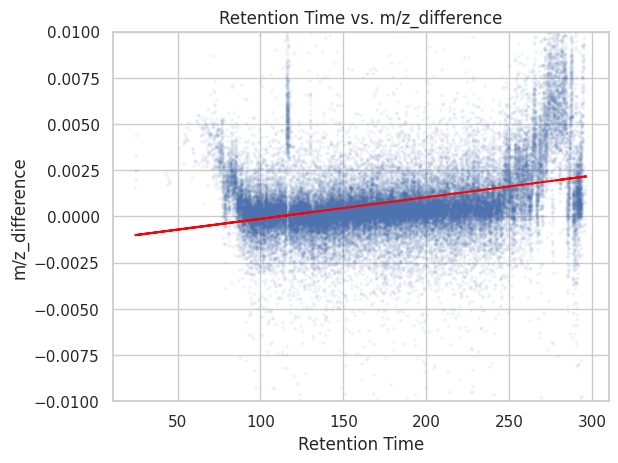

Slope: 1.1683813135066483e-05
Intercept: -0.0012973632642102819


In [15]:
#Compute LR and get slope & intercept

import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_uncal_features_nonlin['RT'], df_uncal_features_nonlin['deltaMZ'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_uncal_features_nonlin['RT']
y = df_uncal_features_nonlin['deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

In [17]:
# substract LR 'predicted' deltaMZ from deltaMZ to compute LR adjusted deltaMZ
df_LR_results_nonlin = df_uncal_features_nonlin.copy()
df_LR_results_nonlin['LR adj deltaMZ'] = df_LR_results_nonlin['deltaMZ'] - (df_LR_results_nonlin['RT'] * slope + intercept)
df_LR_results_nonlin.head(5)

,expMZ,RT,TIC,IT,deltaMZ,LR adj deltaMZ
0,975.003300,129.243130,7500433.5,120.000,-0.001416,-0.001628
1,773.396800,125.368490,4105269.0,94.357,-0.000201,-0.000368
2,704.730900,145.554790,14810754.0,41.438,0.000137,-0.000266
3,847.465454,88.991208,7009052.5,64.821,0.000236,0.000494
4,907.014300,208.323210,7130228.0,120.000,0.001768,0.000631


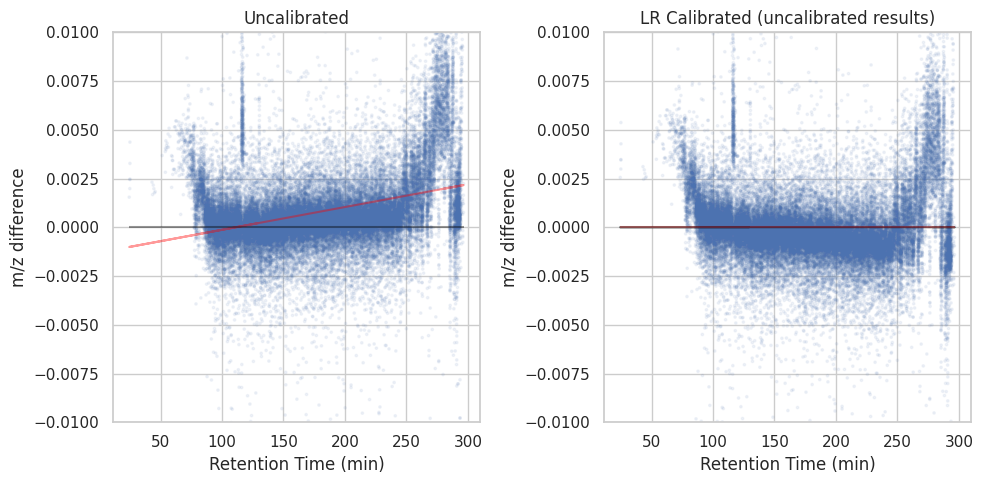

In [18]:
#Plot uncalibrated deltaMZ over RT & LR calibrated deltaMZ over RT

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
axs[0].scatter(df_LR_results_nonlin['RT'], df_LR_results_nonlin['deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_LR_results_nonlin['RT']
y = df_LR_results_nonlin['deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
axs[0].plot(x, polynomial(x), color='red', alpha=0.4)

# Get the x-range of the data in the second subplot
x_range = df_LR_results_nonlin['RT']

# Add horizontal line at y=0 with the same x-range as the data in the second subplot
axs[0].hlines(0, min(x_range), max(x_range), colors='black', alpha=0.4)

axs[0].set_ylim(-0.01, 0.01)
axs[0].set_xlabel('Retention Time (min)')
axs[0].set_ylabel('m/z difference')
axs[0].set_title('Uncalibrated')

# Second subplot
axs[1].scatter(df_LR_results_nonlin['RT'], df_LR_results_nonlin['LR adj deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_LR_results_nonlin['RT']
y = df_LR_results_nonlin['LR adj deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

axs[1].hlines(0, min(x_range), max(x_range), colors='red', alpha=0.4)

axs[1].plot(x, polynomial(x), color='black', alpha=0.4)
axs[1].set_ylim(-0.01, 0.01)
axs[1].set_xlabel('Retention Time (min)')
axs[1].set_ylabel('m/z difference')
axs[1].set_title('LR Calibrated (uncalibrated results)')

plt.tight_layout()
plt.show()

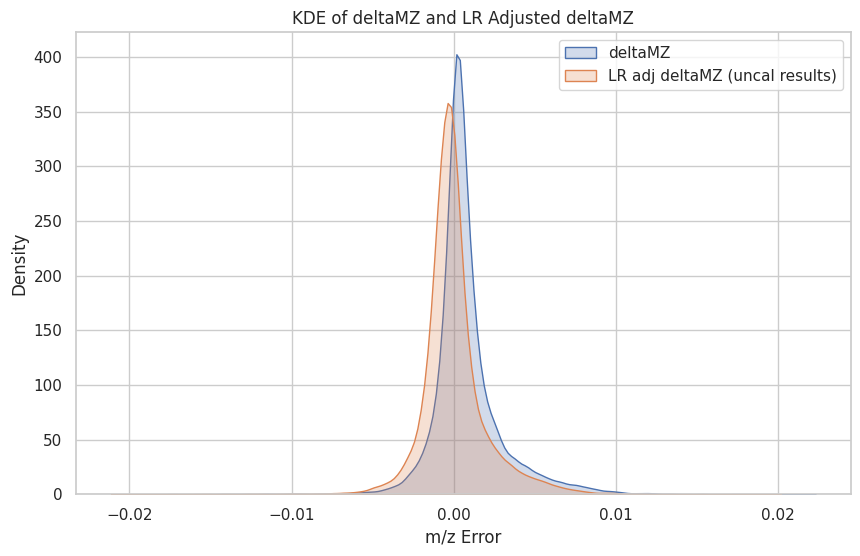

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot KDE for 'm/z error'
sns.kdeplot(df_LR_results_nonlin['deltaMZ'], label='deltaMZ', fill=True)

# Plot KDE for 'RF predicted m/z error'
sns.kdeplot(df_LR_results_nonlin['LR adj deltaMZ'], label='LR adj deltaMZ (uncal results)', fill=True)

# Set title and labels
plt.title('KDE of deltaMZ and LR Adjusted deltaMZ')
plt.xlabel('m/z Error')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

In [21]:
# Apply the LR model to ALL m/z values in the uncalibrated mzML file to adjust the expMZ values
from psims.transform.mzml import MzMLTransformer

def LRcal(spectrum):
    retention_time = spectrum['scanList']['scan'][0]['scan start time']
    mz_values = spectrum['m/z array']
    
    # Apply the calibration function to the m/z values
    calibrated_mz_values = mz_values - (retention_time * slope + intercept)
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    
    # If there are selected ions, calibrate their m/z values as well
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
            and spectrum['precursorList']['precursor'] \
            and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
            and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:
        
        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz = selected_ion.get('selected ion m/z')
            if selected_ion_mz is not None:
                selected_ion_mz_calibrated = selected_ion_mz - (retention_time * slope + intercept)
                selected_ion['selected ion m/z'] = selected_ion_mz_calibrated
    
    return spectrum

with open("data/20210120_HM_HEK_IAA_300minGr_R1.mzML", 'rb') as in_stream, \
        open("data/PXD032235_LRcal.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, LRcal).write()

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H

When the original/uncalibrated mzML file is adjusted/calibrated, run it through sage with the same fasta file and search parameters file, here: 
- fasta file:               human_ref_prot_and_contaminants.fasta
- search parameter file:    SearchClosed.json

Random Forest (RF) Calibration

PXD001468

In [22]:
# train a RF regressor model on the confident predictions (analogous to the LR model)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
data = df_uncal_features

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['deltaMZ'])  # Features
y = data['deltaMZ']  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_regressor.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 1.8461352294568739e-06


In [23]:
# substract LR 'predicted' deltaMZ from deltaMZ to compute LR adjusted deltaMZ
df_RF_results = df_uncal_features.copy()
df_RF_results['RF adj deltaMZ'] = df_RF_results['deltaMZ'] - rf_regressor.predict(df_RF_results[['expMZ', 'RT', 'TIC', 'IT']])
df_RF_results.head(5)

,expMZ,RT,TIC,IT,deltaMZ,RF adj deltaMZ
0,732.375183,63.545262,6076878.5,60.0,0.001966,0.000211
1,1068.018300,148.783380,13360974.0,60.0,0.003680,0.000128
2,847.855225,34.836664,2601142.0,60.0,0.001539,-0.000070
3,889.445923,145.660350,4418031.5,60.0,0.001578,-0.001042
4,783.403198,187.849390,7656454.0,60.0,0.001643,-0.000086


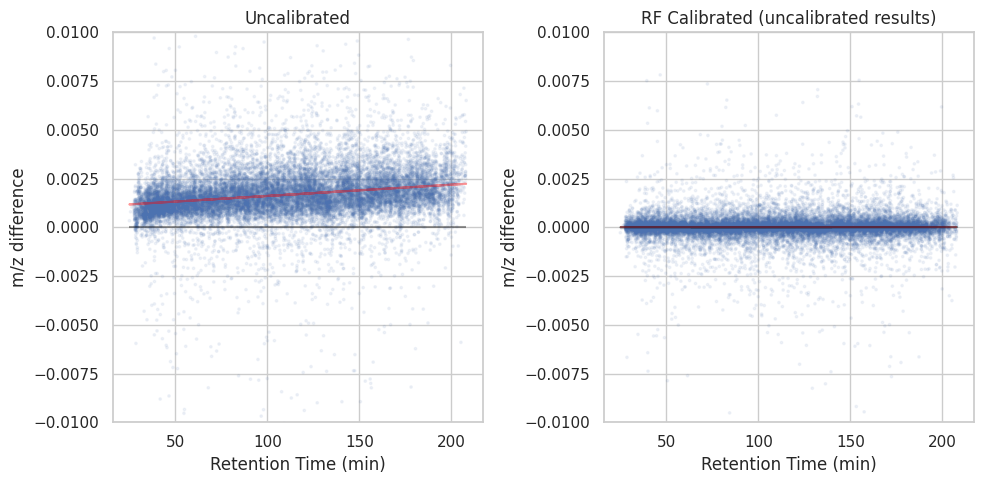

In [24]:
#Plot uncalibrated deltaMZ over RT & RF calibrated deltaMZ over RT

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
axs[0].scatter(df_RF_results['RT'], df_RF_results['deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_RF_results['RT']
y = df_RF_results['deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
axs[0].plot(x, polynomial(x), color='red', alpha=0.4)

# Get the x-range of the data in the second subplot
x_range = df_RF_results['RT']

# Add horizontal line at y=0 with the same x-range as the data in the second subplot
axs[0].hlines(0, min(x_range), max(x_range), colors='black', alpha=0.4)

axs[0].set_ylim(-0.01, 0.01)
axs[0].set_xlabel('Retention Time (min)')
axs[0].set_ylabel('m/z difference')
axs[0].set_title('Uncalibrated')

# Second subplot
axs[1].scatter(df_RF_results['RT'], df_RF_results['RF adj deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_RF_results['RT']
y = df_RF_results['RF adj deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

axs[1].hlines(0, min(x_range), max(x_range), colors='red', alpha=0.4)

axs[1].plot(x, polynomial(x), color='black', alpha=0.4)
axs[1].set_ylim(-0.01, 0.01)
axs[1].set_xlabel('Retention Time (min)')
axs[1].set_ylabel('m/z difference')
axs[1].set_title('RF Calibrated (uncalibrated results)')

plt.tight_layout()
plt.show()

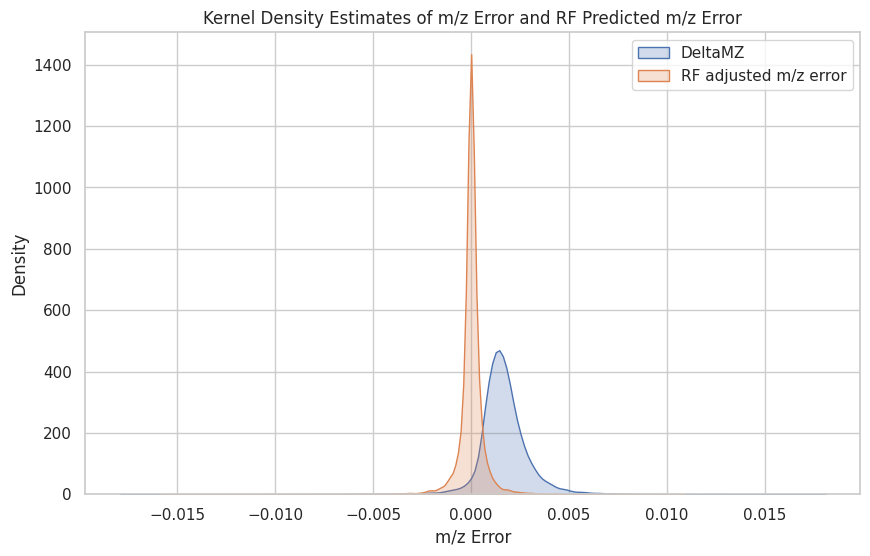

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot KDE for 'm/z error'
sns.kdeplot(df_RF_results['deltaMZ'], label='DeltaMZ', fill=True)

# Plot KDE for 'RF predicted m/z error'
sns.kdeplot(df_RF_results['RF adj deltaMZ'], label='RF adjusted m/z error', fill=True)

# Set title and labels
plt.title('Kernel Density Estimates of m/z Error and RF Predicted m/z Error')
plt.xlabel('m/z Error')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

In [26]:
def get_x(spectrum):
    mz_values = spectrum['m/z array']
    retention_time = float(spectrum['scanList']['scan'][0]['scan start time'])
    total_ion_count = float(spectrum['total ion current'])
    injection_time = float(spectrum['scanList']['scan'][0]['ion injection time'])
    x = [[mz_value, retention_time, total_ion_count, injection_time] for mz_value in mz_values]
    return x

In [27]:
import warnings
import numpy as np
from psims.transform.mzml import MzMLTransformer

# Suppress UserWarning about feature names
warnings.filterwarnings("ignore", category=UserWarning)

def get_x(spectrum):
    mz_values = spectrum['m/z array']
    retention_time = float(spectrum['scanList']['scan'][0]['scan start time'])
    total_ion_count = float(spectrum['total ion current'])
    injection_time = float(spectrum['scanList']['scan'][0]['ion injection time'])
    x = [[mz_value, retention_time, total_ion_count, injection_time] for mz_value in mz_values]
    return x

def RFcal(spectrum):
    mz_values = spectrum['m/z array']
    x = get_x(spectrum)
    retention_time = float(spectrum['scanList']['scan'][0]['scan start time'])
    total_ion_count = float(spectrum['total ion current'])
    injection_time = float(spectrum['scanList']['scan'][0]['ion injection time'])
    
    # Apply the calibration function to the m/z values
    calibrated_mz_values = np.array(mz_values) - np.array(rf_regressor.predict(x))
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    
    # If there are selected ions, calibrate their m/z values as well
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
            and spectrum['precursorList']['precursor'] \
            and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
            and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:
        
        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz_str = selected_ion.get('selected ion m/z')
            if selected_ion_mz_str is not None:
                # Extract the numerical value from the string representation
                selected_ion_mz = float(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])
                
                # Create features for prediction for the selected ion
                x_selected_ion = np.array([[selected_ion_mz, retention_time, total_ion_count, injection_time]])
                
                # Calibrate the selected ion m/z value
                calibrated_selected_ion_mz = str(selected_ion_mz - rf_regressor.predict(x_selected_ion))[1:-1]
                selected_ion['selected ion m/z'] = calibrated_selected_ion_mz
    
    return spectrum

with open("data/b1948_293T_proteinID_12B_QE3_122212.mzML", 'rb') as in_stream, open("data/PXD001468_RFcal.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, RFcal).write()

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H

When the original/uncalibrated mzML file is adjusted/calibrated, run it through sage with the same fasta file and search parameters file, here: 
- fasta file:               human_ref_prot_and_contaminants.fasta
- search parameter file:    SearchClosed.json

PXD032235

In [28]:
# train a RF regressor model on the confident predictions (analogous to the LR model)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
data = df_uncal_features_nonlin

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['deltaMZ'])  # Features
y = data['deltaMZ']  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_regressor.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.5701904700746278e-06


In [29]:
# substract LR 'predicted' deltaMZ from deltaMZ to compute LR adjusted deltaMZ
df_RF_results_nonlin = df_uncal_features_nonlin.copy()
df_RF_results_nonlin['RF adj deltaMZ'] = df_RF_results_nonlin['deltaMZ'] - rf_regressor.predict(df_RF_results_nonlin[['expMZ', 'RT', 'TIC', 'IT']])
df_RF_results_nonlin.head(5)

,expMZ,RT,TIC,IT,deltaMZ,RF adj deltaMZ
0,975.003300,129.243130,7500433.5,120.000,-0.001416,-0.000263
1,773.396800,125.368490,4105269.0,94.357,-0.000201,-0.000155
2,704.730900,145.554790,14810754.0,41.438,0.000137,-0.000160
3,847.465454,88.991208,7009052.5,64.821,0.000236,0.000221
4,907.014300,208.323210,7130228.0,120.000,0.001768,0.001293


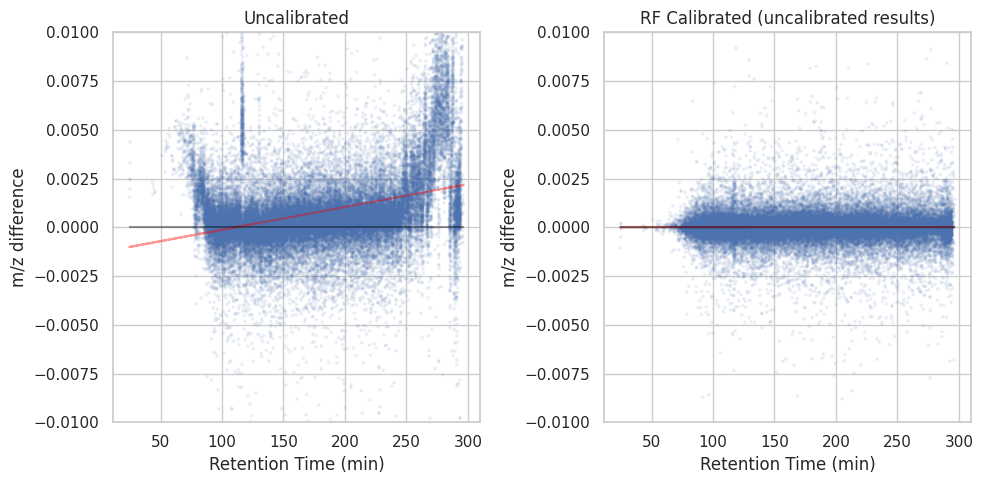

In [30]:
#Plot uncalibrated deltaMZ over RT & RF calibrated deltaMZ over RT

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
axs[0].scatter(df_RF_results_nonlin['RT'], df_RF_results_nonlin['deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_RF_results_nonlin['RT']
y = df_RF_results_nonlin['deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
axs[0].plot(x, polynomial(x), color='red', alpha=0.4)

# Get the x-range of the data in the second subplot
x_range = df_RF_results_nonlin['RT']

# Add horizontal line at y=0 with the same x-range as the data in the second subplot
axs[0].hlines(0, min(x_range), max(x_range), colors='black', alpha=0.4)

axs[0].set_ylim(-0.01, 0.01)
axs[0].set_xlabel('Retention Time (min)')
axs[0].set_ylabel('m/z difference')
axs[0].set_title('Uncalibrated')

# Second subplot
axs[1].scatter(df_RF_results_nonlin['RT'], df_RF_results_nonlin['RF adj deltaMZ'], marker='o', linestyle='', alpha=0.075, s=3)
x = df_RF_results_nonlin['RT']
y = df_RF_results_nonlin['RF adj deltaMZ']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

axs[1].hlines(0, min(x_range), max(x_range), colors='red', alpha=0.4)

axs[1].plot(x, polynomial(x), color='black', alpha=0.4)
axs[1].set_ylim(-0.01, 0.01)
axs[1].set_xlabel('Retention Time (min)')
axs[1].set_ylabel('m/z difference')
axs[1].set_title('RF Calibrated (uncalibrated results)')

plt.tight_layout()
plt.show()

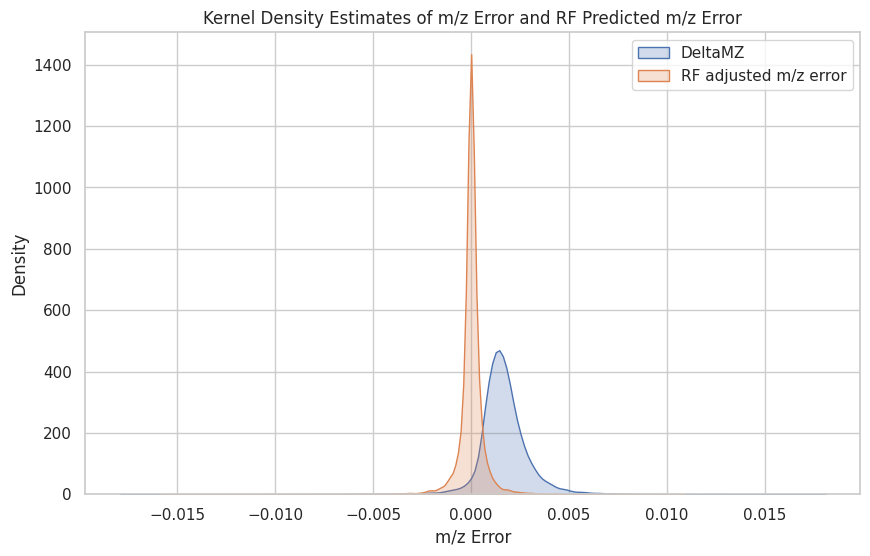

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot KDE for 'm/z error'
sns.kdeplot(df_RF_results['deltaMZ'], label='DeltaMZ', fill=True)

# Plot KDE for 'RF predicted m/z error'
sns.kdeplot(df_RF_results['RF adj deltaMZ'], label='RF adjusted m/z error', fill=True)

# Set title and labels
plt.title('Kernel Density Estimates of m/z Error and RF Predicted m/z Error')
plt.xlabel('m/z Error')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

In [32]:
def get_x(spectrum):
    mz_values = spectrum['m/z array']
    retention_time = float(spectrum['scanList']['scan'][0]['scan start time'])
    total_ion_count = float(spectrum['total ion current'])
    injection_time = float(spectrum['scanList']['scan'][0]['ion injection time'])
    x = [[mz_value, retention_time, total_ion_count, injection_time] for mz_value in mz_values]
    return x

In [34]:
import warnings
import numpy as np
from psims.transform.mzml import MzMLTransformer

# Suppress UserWarning about feature names
warnings.filterwarnings("ignore", category=UserWarning)

def get_x(spectrum):
    mz_values = spectrum['m/z array']
    retention_time = float(spectrum['scanList']['scan'][0]['scan start time'])
    total_ion_count = float(spectrum['total ion current'])
    injection_time = float(spectrum['scanList']['scan'][0]['ion injection time'])
    x = [[mz_value, retention_time, total_ion_count, injection_time] for mz_value in mz_values]
    return x

def RFcal(spectrum):
    mz_values = spectrum['m/z array']
    x = get_x(spectrum)
    retention_time = float(spectrum['scanList']['scan'][0]['scan start time'])
    total_ion_count = float(spectrum['total ion current'])
    injection_time = float(spectrum['scanList']['scan'][0]['ion injection time'])
    
    # Apply the calibration function to the m/z values
    calibrated_mz_values = np.array(mz_values) - np.array(rf_regressor.predict(x))
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    
    # If there are selected ions, calibrate their m/z values as well
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
            and spectrum['precursorList']['precursor'] \
            and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
            and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:
        
        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz_str = selected_ion.get('selected ion m/z')
            if selected_ion_mz_str is not None:
                # Extract the numerical value from the string representation
                selected_ion_mz = float(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])
                
                # Create features for prediction for the selected ion
                x_selected_ion = np.array([[selected_ion_mz, retention_time, total_ion_count, injection_time]])
                
                # Calibrate the selected ion m/z value
                calibrated_selected_ion_mz = str(selected_ion_mz - rf_regressor.predict(x_selected_ion))[1:-1]
                selected_ion['selected ion m/z'] = calibrated_selected_ion_mz
    
    return spectrum

with open("data/20210120_HM_HEK_IAA_300minGr_R1.mzML", 'rb') as in_stream, open("data/PXD032235_RFcal.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, RFcal).write()

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H

When the original/uncalibrated mzML file is adjusted/calibrated, run it through sage with the same fasta file and search parameters file, here: 
- fasta file:               human_ref_prot_and_contaminants.fasta
- search parameter file:    SearchClosed.json